[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeljov/NAP2025/blob/main/Pride_and_Prejudice_network_analysis.ipynb)

## Text analytics and SNA applied to Jane Austen's "Pride and Prejudice" novel

[Pride and Prejudice](https://www.goodreads.com/book/show/129915654-pride-and-prejudice) is one of the most beloved English classic novels from the first half of the 19th century. As is the case with many other classics, the novel is made publicly available as a part of the [Project Gutenberg](https://www.gutenberg.org/).

Similar to how movie scripts were used at [Movie Galaxies](https://moviegalaxies.com/) to build networks of movie characters, we will use the (publicly available) text of Pride and Prejudice to create a social network of its characters. In the case of networks of movie character, two characters are connected if they occur in the same scene. Analogous to that, we will create a network, where two characters are connected if they occur in the same paragraph, and the frequncy of their co-occurrence will be reflected in the weight of the edge that connects them.

To build such a network, we will adopt the following method:
* **Download and preprocess the book content**. Download the book as a .txt file either directly from [Project Gutenberg](https://www.gutenberg.org/ebooks/1342) of from one of many public repos where it is available. Then, split the book into volumes and chapters, and do some text cleaning along the way.
* **Collect data about the book characters**. Look for a place on the net where the list of book characters can be found - this will be needed to properly identify characters in the text. For example, one such list is available [here](https://austenprose.com/pride-and-prejudice-character-list/), as a part of website that is generally about Jane Austen's work and can be considered as a credible source. Extract the list of characters and make it available for the entity extraction task.
* **Do paragraph-level enitity (character) extraction**. Extract entities from each book paragraph using spaCy for tokenisation and entity detection. Since [spaCy's NER (Named Entity Recognition) module](https://spacy.io/models/en) was trained on news arcticle and web content, it is not able to handle the text of a 19th century novel properly. Thus, we need to define a set of custom rules for the entity detection task.
* **Create an edge list**. Recall that a typical source for network creation is an edge list. So, having identified entities in each paragraph, for each paragraph with at least two entities detected, we add all pairs of the identified entities to an edge list. For example, if Elizabeth, Jane, and Darcy are mentioned in one paragraph, we would add three edges to the edge list: Elizabeth - Jane, Elizabeth - Darcy, and Jane - Darcy. After all edges (i.e., detected entity pairs) have been added to the edge list, reduce the list by introducing edge weight, so that instead of having multiple occurrences of the same edge, we have one edge occurrence with the weight reflecting its frequency.
* **Create and visualise the (paragraph-level) network**. The edge list can be directly used to create a network using the networkX library. Then we visualise and explore the network.
* **Explore the network**. Compute the basic netowrk statistics and identify the most central characters. Examine how connected the networkk is and if some communities can be detected.



### Instal and load the required libraries

In [1]:
# pyvis is a network visualisation library capable of much better network visualisation compared to that provided by networkX
# https://pypi.org/project/pyvis/

!pip install -q pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup

from google.colab import files
import pickle

from collections import defaultdict

import re
import spacy

import networkx as nx

from pyvis.network import Network
import IPython

import warnings

### Download and preprocess the book content

The book content was downloaded from [this GitHub repo](https://github.com/laumann/ds/blob/master/hashing/books/) and stored localy.

In [3]:
book_file = files.upload()

Saving jane-austen-pride-prejudice.txt to jane-austen-pride-prejudice.txt


In [4]:
with open('jane-austen-pride-prejudice.txt', 'r') as fobj:
  book_raw_txt = fobj.read()

print(len(book_raw_txt))

711333


Split the book content into volumes, chapters, and eventually paragrpahs

In [5]:
# Regarding the regex patterns below:
# \s+ matches one or more whitespace characters
# [IVXLCDM]+ matches one or more Roman numeral characters
# \. captures the dot at the end of the chapter number
volume_pattern = r'(VOL\.\s+[IVXLCDM]+\.)'
chapter_pattern = r'(CHAPTER\s+[IVXLCDM]+\.)'

# split the text into volumes
# note that we included parentheses in the pattern to keep the volume titles in the text
book_volumes = re.split(volume_pattern, book_raw_txt)

# the text of VOL. I is preceded by the 'preface'
preamble = book_volumes[0]

chapters = list()

for i in range(1, len(book_volumes)-1, 2):
    volume_lbl = book_volumes[i].strip()
    volume_content = book_volumes[i+1].strip()

    # split a volume into chapters
    volume_chapters = re.split(chapter_pattern, volume_content)
    # skip the content before the first chapter, it's a preface
    for i in range(1, len(volume_chapters)-1, 2):
      chapter_lbl = volume_chapters[i].strip()
      chapter_content = volume_chapters[i+1].strip().strip("\n")
      chapters.append({
          'volume':volume_lbl,
          'chapter':chapter_lbl,
          'content':chapter_content
      })



In [6]:
len(chapters)

61

In [7]:
print(chapters[0])

{'volume': 'VOL. I.', 'chapter': 'CHAPTER I.', 'content': 'It is a truth universally acknowledged, that a single man in possession\nof a good fortune, must be in want of a wife.\n\nHowever little known the feelings or views of such a man may be on his\nfirst entering a neighbourhood, this truth is so well fixed in the minds\nof the surrounding families, that he is considered as the rightful\nproperty of some one or other of their daughters.\n\n"My dear Mr. Bennet," said his lady to him one day, "have you heard that\nNetherfield Park is let at last?"\n\nMr. Bennet replied that he had not.\n\n"But it is," returned she; "for Mrs. Long has just been here, and she\ntold me all about it."\n\nMr. Bennet made no answer.\n\n"Do not you want to know who has taken it?" cried his wife impatiently.\n\n"_You_ want to tell me, and I have no objection to hearing it."\n\nThis was invitation enough.\n\n"Why, my dear, you must know, Mrs. Long says that Netherfield is taken\nby a young man of large fortun

### Collect data about the book characters

The character data will be collected by scraping the relevant content of the [Pride and Prejudice: List of Characters](https://austenprose.com/pride-and-prejudice-character-list/) page.

In [8]:
char_groups = ['Longbourn', 'Netherfield Park', 'Lucas Lodge', 'Meryton', 'Rosings Park', 'Pemberley', 'Town', 'Regiment']

In [9]:
characters = defaultdict(list)
url = "https://austenprose.com/pride-and-prejudice-character-list/"

try:
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    main_chars_elem = soup.find(lambda elem: (elem.name=='div') and elem.has_attr('class') and (elem['class'][0] == 'post-content'))

    current_char_group = ""
    for elem in main_chars_elem.find_all(lambda elem: elem.name in ['h3', 'p']):

      if (elem.name == 'h3'):
        if elem.text.strip() == "Minor Characters":
          break
        group_lbl = elem.text.split(maxsplit=1)[1].strip()
        if (group_lbl in char_groups) and (current_char_group != group_lbl):
          current_char_group = group_lbl

      if (current_char_group != "") and (elem.name == 'p') and (elem.find_next(name='strong')):
          char_in_bold = elem.find_next('strong')
          characters[current_char_group].append({'name': char_in_bold.text, 'description':elem.text})

except Exception as e:
    print(e)
    print(e.with_traceback)

In [10]:
characters_list = list()
for char_group, char_list in characters.items():
  for char in char_list:
    char.update({'group':char_group})
    characters_list.append(char)

In [11]:
len(characters_list)

31

In [12]:
for char in characters_list[:5]:
  print(char)

{'name': 'Mr. Bennet', 'description': 'Mr. Bennet: of Longbourn-house, Hertfordshire. Entailed estate with £2,000 a year. Married to Mrs. Bennet.', 'group': 'Longbourn'}
{'name': 'Mrs. Bennet', 'description': 'Mrs. Bennet: Nee Gardiner of Meryton with a £5,000 dowry. Sister of Edward Gardiner of Gracechurch Street, London and Mrs. Phillips of Meryton. Children: Jane, Elizabeth, Mary, Catherine and Lydia', 'group': 'Longbourn'}
{'name': 'Miss Jane Bennet', 'description': 'Miss Jane Bennet: Eldest unmarried Bennet daughter. Age 22. Dowry of £1,000. Marries Charles Bingley', 'group': 'Longbourn'}
{'name': 'Miss Elizabeth Bennet', 'description': 'Miss Elizabeth Bennet: Heroine. Second unmarried Bennet daughter. Age 20. Dowry of £1,000. A reputed beauty with fine eyes. Nicknames Eliza & Lizzy. Marries Fitzwilliam Darcy', 'group': 'Longbourn'}
{'name': 'Miss Mary Bennet', 'description': 'Miss Mary Bennet: Third unmarried Bennet daughter. Dowry of £1,000. Pedantic', 'group': 'Longbourn'}


In [13]:
characters_df = pd.DataFrame(characters_list)

print(characters_df.shape)
characters_df.head()

(31, 3)


,name,description,group
0,Mr. Bennet,"Mr. Bennet: of Longbourn-house, Hertfordshire....",Longbourn
1,Mrs. Bennet,Mrs. Bennet: Nee Gardiner of Meryton with a £5...,Longbourn
2,Miss Jane Bennet,Miss Jane Bennet: Eldest unmarried Bennet daug...,Longbourn
3,Miss Elizabeth Bennet,Miss Elizabeth Bennet: Heroine. Second unmarri...,Longbourn
4,Miss Mary Bennet,Miss Mary Bennet: Third unmarried Bennet daugh...,Longbourn


In [14]:
characters_df.tail()

,name,description,group
26,Colonel Forster,Colonel Forster: Commanding Officer of the ___...,Regiment
27,Mrs. Harriet Forster,Mrs. Harriet Forster: Col. Forster’s wife,Regiment
28,Mr. George Wickham,Mr. George Wickham: A Lieutenant of the ___shi...,Regiment
29,Mr. Edward Gardiner,"Mr. Edward Gardiner: of Gracechurch street, Lo...",Town
30,Mrs. Gardiner,"Mrs. Gardiner: of Gracechurch street, London. ...",Town


In [15]:
characters_df.name.tolist()

['Mr. Bennet',
 'Mrs. Bennet',
 'Miss Jane Bennet',
 'Miss Elizabeth Bennet',
 'Miss Mary Bennet',
 'Miss Catherine Bennet',
 'Miss Lydia Bennet',
 'Mr. Charles Bingley',
 'Mr. Hurst',
 'Mrs. Louisa Hurst',
 'Miss Caroline Bingley',
 'Sir William Lucas',
 'Lady Lucas',
 'Miss Charlotte Lucas',
 'Miss Maria Lucas',
 'Mr. Phillips',
 'Mrs. Phillips',
 'Sir Lewis de Bourgh',
 'Rt. Hon. Lady Catherine de Bourgh',
 'Miss Anne de Bourgh',
 'Colonel Fitzwilliam',
 'Rev. William Collins',
 'Mr. Darcy (the elder)',
 'Lady Anne Darcy',
 'Mr. Fitzwilliam Darcy',
 'Miss Georgiana Darcy',
 'Colonel Forster',
 'Mrs. Harriet Forster',
 'Mr. George Wickham',
 'Mr. Edward Gardiner',
 'Mrs. Gardiner']

Since each character can be referenced in the text in many different ways, we will first split the full name into segments (title, first name, last name) in order to be able to create various versions of character mentions in the text.

In [16]:
def extract_title_firstname_surname(full_name):
  name_parts = full_name.split()
  if len(name_parts) == 2:
    title, surname = name_parts
    return title, None, surname
  elif len(name_parts) == 3:
    title, fname, surname = name_parts
    return title, fname, surname
  else:
    surname = " ".join(name_parts[-2:])
    fname = name_parts[-3]
    n = len(name_parts)
    title = " ".join(name_parts[0:(n-3)])
    return title, fname, surname

In [17]:
name_parts_df = characters_df.name.apply(extract_title_firstname_surname).apply(pd.Series)
name_parts_df.columns = ['title', 'first_name', 'last_name']

pride_prej_chars_df = pd.concat([name_parts_df, characters_df], axis=1)
pride_prej_chars_df

,title,first_name,last_name,name,description,group
0,Mr.,None,Bennet,Mr. Bennet,"Mr. Bennet: of Longbourn-house, Hertfordshire....",Longbourn
1,Mrs.,None,Bennet,Mrs. Bennet,Mrs. Bennet: Nee Gardiner of Meryton with a £5...,Longbourn
2,Miss,Jane,Bennet,Miss Jane Bennet,Miss Jane Bennet: Eldest unmarried Bennet daug...,Longbourn
3,Miss,Elizabeth,Bennet,Miss Elizabeth Bennet,Miss Elizabeth Bennet: Heroine. Second unmarri...,Longbourn
4,Miss,Mary,Bennet,Miss Mary Bennet,Miss Mary Bennet: Third unmarried Bennet daugh...,Longbourn
5,Miss,Catherine,Bennet,Miss Catherine Bennet,Miss Catherine Bennet: Fourth unmarried Bennet...,Longbourn
6,Miss,Lydia,Bennet,Miss Lydia Bennet,Miss Lydia Bennet: Fifth unmarried Bennet daug...,Longbourn
7,Mr.,Charles,Bingley,Mr. Charles Bingley,Mr. Charles Bingley: of Netherfield Park and L...,Netherfield Park
8,Mr.,None,Hurst,Mr. Hurst,"Mr. Hurst: of Grosvenor street, London. Marrie...",Netherfield Park
9,Mrs.,Louisa,Hurst,Mrs. Louisa Hurst,"Mrs. Louisa Hurst: of Grosvenor street, London...",Netherfield Park


We will now add a column with all possible name variants to look for in the text:
* full name,
* title + first name (if first name exists)
* title + surname (if first name exists),
* first name only (if it exists),
* special cases:
  * include nicknames "Lizzy" and "Eliza" for Elizabeth, as well as "Mrs. Darcy" (what she becomes at the very end),
  * include nickname "Kitty" for Catherine Bennet
  * include surnames (without the title) for Bingly and Darcy, as they are often referenced like that in the book
  * Darcy is never referred to by his first name and it might be better not included not to mix him with Colonel Fitzwilliam, his cousin.
  * exclude the title + surname combination for the Bennet sisters as for them this combination is the same and thus introduces ambiguity
  * include "Lady Catherine" for Rt. Hon. Lady Catherine de Bourgh
  * include labels 'the late Mr. Darcy', 'the elder Mr. Darcy', and "old Mr. Darcy", for Mr. Darcy's father; this is to handle the ambiguity that tends to arise from both the father and the son being referred to "Mr. Darcy".

In [18]:
chars_name_variants = []

for _, row in pride_prej_chars_df.iterrows():
  fn = row['first_name']
  ln = row['last_name']
  title = row['title']

  name_variants = [row['name']]

  if fn:
    name_variants.extend([f"{title} {fn}", f"{fn} {ln}"])

  # the following one is to add the title + surname combination for all with the first name
  # except for the Bennet sisters - see the special rules above
  if fn and (ln != "Bennet"):
    name_variants.append(f"{title} {ln}")

  # the following one is to add the first name for all characters except Darcy - see the special rules above
  if fn and (ln != "Darcy"):
    name_variants.append(fn)

  if row['name'] == 'Miss Elizabeth Bennet':
    name_variants.extend(['Lizzy', 'Eliza', 'Miss Eliza', 'Mrs. Darcy'])

  if row['name'] == 'Miss Catherine Bennet':
    name_variants.extend(['Kitty', 'Miss Kitty'])

  if row['name'] in ['Mr. Charles Bingley', 'Mr. Fitzwilliam Darcy']:
    name_variants.append(ln)

  if row['name'] == 'Mr. Darcy (the elder)':
    name_variants = ['the late Mr. Darcy', 'the elder Mr. Darcy']

  chars_name_variants.append({
      'name': row['name'],
      'name_variants': name_variants
  })

chars_name_variants_df = pd.DataFrame(chars_name_variants)
#chars_name_variants_df

In [19]:
pride_prej_chars_df = pd.merge(pride_prej_chars_df, chars_name_variants_df, on='name', how='inner')
pride_prej_chars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          31 non-null     object
 1   first_name     22 non-null     object
 2   last_name      31 non-null     object
 3   name           31 non-null     object
 4   description    31 non-null     object
 5   group          31 non-null     object
 6   name_variants  31 non-null     object
dtypes: object(7)
memory usage: 1.8+ KB


In [20]:
pride_prej_chars_df.head()

,title,first_name,last_name,name,description,group,name_variants
0,Mr.,None,Bennet,Mr. Bennet,"Mr. Bennet: of Longbourn-house, Hertfordshire....",Longbourn,[Mr. Bennet]
1,Mrs.,None,Bennet,Mrs. Bennet,Mrs. Bennet: Nee Gardiner of Meryton with a £5...,Longbourn,[Mrs. Bennet]
2,Miss,Jane,Bennet,Miss Jane Bennet,Miss Jane Bennet: Eldest unmarried Bennet daug...,Longbourn,"[Miss Jane Bennet, Miss Jane, Jane Bennet, Jane]"
3,Miss,Elizabeth,Bennet,Miss Elizabeth Bennet,Miss Elizabeth Bennet: Heroine. Second unmarri...,Longbourn,"[Miss Elizabeth Bennet, Miss Elizabeth, Elizab..."
4,Miss,Mary,Bennet,Miss Mary Bennet,Miss Mary Bennet: Third unmarried Bennet daugh...,Longbourn,"[Miss Mary Bennet, Miss Mary, Mary Bennet, Mary]"


In [21]:
pride_prej_chars_df.to_csv("pride_and_prejudice_characters.csv", index=False)
files.download("pride_and_prejudice_characters.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Do paragraph-level enitity (character) extraction

Install a spaCy model for text processing.

In [22]:
!python3 -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 58.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Prepare a list of dictionaries, where key is the full character name (as identifier) and the value is a list of different ways this character may appear in text. This will be needed for setting rules for character detection

In [23]:
characters_in_text_dict = dict()

for _, row in pride_prej_chars_df.iterrows():
  characters_in_text_dict[row['name']] = row['name_variants']

# for k, v in characters_in_text_dict.items():
#   print(f"{k}: {v}")

Load the NLP model and define a set of custom rules for character detection

In [24]:
spacy_pipeline = spacy.load("en_core_web_md")

# add the ruler BEFORE the ner
ruler = spacy_pipeline.add_pipe("entity_ruler", before="ner")
ruler.overwrite_ents = True

# patterns to be used for identifying characters in the text
patterns = []

# # first, add general templates of the kind: Title + Capitalized Word
# titles = ["Mr.", "Mrs.", "Miss", "Lady", "Sir", "Rev.", "Colonel"]
# for title in titles:
#     patterns.append({
#         "label": "PERSON",
#         "pattern": [{"LOWER": title.lower()}, {"IS_TITLE": True}]
#     })

# next, create patterns for specific name combinations
for full_name, name_variants in characters_in_text_dict.items():
  char_id = "_".join(full_name.split())
  for name in name_variants:
      patterns.append({"label": "PERSON", "pattern": name, "id":char_id})

# load all the patterns into the ruler
ruler.add_patterns(patterns)

In [25]:
# test the pipeline
doc = spacy_pipeline("Mr. Bennet and George Wickham both knew Elizabeth Bennet.")
for ent in doc.ents:
    print(f"{ent.text} ({ent.label_}) ({ent.id_})")

Mr. Bennet (PERSON) (Mr._Bennet)
George Wickham (PERSON) (Mr._George_Wickham)
Elizabeth Bennet (PERSON) (Miss_Elizabeth_Bennet)


Texts downloaded from Project Gutenbeg require some preprocessing to be ready for further analysis. Typical problems include almost randomly put newlines / tabs / multiple spaces as well as '--' connecting two words that should not be connected (e.g., "Mrs. Bennet.--They")

In [26]:
def clean_gutenberg_paragraphs(raw_paragraphs):

    cleaned_paragraphs = []

    for par in raw_paragraphs:
        # replace any internal newlines or tabs or multiple spaces with a single space
        clean_par = re.sub(r'\s+', ' ', par)

        # replace the Gutenberg double-dash with a space-padded version
        # this is to avoid problems with detection of entities (e.g., 'Mrs. Bennet.--They')
        clean_par = clean_par.replace('--', ' -- ')

        # strip leading/trailing whitespace
        clean_par = clean_par.strip()

        if clean_par: # if the paragraph isn't empty
            cleaned_paragraphs.append(clean_par)

    return cleaned_paragraphs

The function below extract characters from individual paragraphs of a book chapter by:
* splitting the chapter into paragraphs
* cleaning the text of those paragraphs
* passing the paragraphs to the spaCy's NLP pipeline for further processing, specifically tokenisation and entity extraction based on custom rules (set above); not that the `parser` and `lemmatizer` are excluded from the pipeline since they are not needed for entity extraction; in addition, the `ner` module is also excluded since it proved not to work well with 19th century language (it eas trained on modern days web and news content)
* filtering out the extracted entities to keep only those of the type PERSON.

In [27]:
def extract_characters_from_chapter(book_chapter: dict, nlp_pipeline) -> list:

  chapter_entity_labels = []
  chapter_entity_ids = []

  chapter_pars = re.split(r'\n\n+', book_chapter['content'])

  cleaned_chapter_pars = clean_gutenberg_paragraphs(chapter_pars)

  processed_paragraphs = nlp_pipeline.pipe(cleaned_chapter_pars, disable=["ner", "parser", "lemmatizer"])

  for p in processed_paragraphs:
      ent_labels = []
      ent_ids = []
      for ent in p.ents:
        if ent.label_ == 'PERSON':
          ent_labels.append(ent.text.strip())
          ent_ids.append(ent.id_)

      chapter_entity_labels.append(ent_labels)
      chapter_entity_ids.append(ent_ids)

  chapter_pars_ents = []
  for par_text, par_ents, par_ent_ids in zip(chapter_pars, chapter_entity_labels, chapter_entity_ids):
    chapter_pars_ents.append({
        'volume': book_chapter['volume'],
        'chapter': book_chapter['chapter'],
        'paragraph': par_text,
        'entity_lbls': set(par_ents),
        'entity_ids': set(par_ent_ids)})

  return chapter_pars_ents

In [28]:
chapters_with_entities = []

for i, chapter in enumerate(chapters):
  if i % 10 == 0: print(f"processing {i+1}. chapter")
  chapters_with_entities.extend(extract_characters_from_chapter(chapter, spacy_pipeline))

print(len(chapters_with_entities))

processing 1. chapter
processing 11. chapter
processing 21. chapter
processing 31. chapter
processing 41. chapter
processing 51. chapter
processing 61. chapter
2122


In [29]:
chapters_with_entities_df = pd.DataFrame(chapters_with_entities)
chapters_with_entities_df.head(10)

,volume,chapter,paragraph,entity_lbls,entity_ids
0,VOL. I.,CHAPTER I.,"It is a truth universally acknowledged, that a...",{},{}
1,VOL. I.,CHAPTER I.,However little known the feelings or views of ...,{},{}
2,VOL. I.,CHAPTER I.,"""My dear Mr. Bennet,"" said his lady to him one...",{Mr. Bennet},{Mr._Bennet}
3,VOL. I.,CHAPTER I.,Mr. Bennet replied that he had not.,{Mr. Bennet},{Mr._Bennet}
4,VOL. I.,CHAPTER I.,"""But it is,"" returned she; ""for Mrs. Long has ...",{},{}
5,VOL. I.,CHAPTER I.,Mr. Bennet made no answer.,{Mr. Bennet},{Mr._Bennet}
6,VOL. I.,CHAPTER I.,"""Do not you want to know who has taken it?"" cr...",{},{}
7,VOL. I.,CHAPTER I.,"""_You_ want to tell me, and I have no objectio...",{},{}
8,VOL. I.,CHAPTER I.,This was invitation enough.,{},{}
9,VOL. I.,CHAPTER I.,"""Why, my dear, you must know, Mrs. Long says t...",{},{}


The code below is just for checking what PERSON type entities have been detected.

In [30]:
# the following line shows how to turn a list of lists into a flat list
# flattened_list = [item for sublist in list_of_lists for item in sublist]

# all_extracted_entities = set([ent for paragraph_ents in chapters_with_entities_df.entity_lbls.to_list() for ent in paragraph_ents])

# all_extracted_entity_ids = set([ent for paragraph_ents in chapters_with_entities_df.entity_ids.to_list() for ent in paragraph_ents])

# print("\n".join(all_extracted_entities))
# print("\n".join(all_extracted_entity_ids))
# print(len(all_extracted_entity_ids))

#### Filter out the extracted entities

We may need to filter out the extracted entities to keep only those who are really book characters. To that end, we will use the data about the book characters that were collected from the web.

Note: this step is required only if we use some more general rules for entity detection - for example, rules of the type: Title + Capitalized Word, as given (and commented out) in the code above.

In [31]:
def check_entity(ent_label):
  for full_name, name_variants in characters_in_text_dict.items():
    if ent_label in name_variants:
      return full_name
  # if the entity label is not associated with any known entity
  return None

true_ents_in_pars = []

for _, row in chapters_with_entities_df.iterrows():
  if not row['entity_lbls'] or len(row['entity_lbls']) == 0:
    continue

  par_ents = []
  for ent_lbl in row['entity_lbls']:
    ent_id = check_entity(ent_lbl)
    if ent_id:
      par_ents.append(ent_id)

  if len(par_ents) > 0:

    vol_num = row['volume'].split()[1]
    chapt_num = row['chapter'].split()[1]
    vol_chapt = f"{vol_num.strip('.')}_{chapt_num.strip('.')}"

    true_ents_in_pars.append({
        'chapter': vol_chapt,
        'paragraph': row['paragraph'],
        'chars' : set(par_ents)
    })

In [32]:
true_ents_in_pars_df = pd.DataFrame(true_ents_in_pars)
true_ents_in_pars_df.head()

,chapter,paragraph,chars
0,I_I,"""My dear Mr. Bennet,"" said his lady to him one...",{Mr. Bennet}
1,I_I,Mr. Bennet replied that he had not.,{Mr. Bennet}
2,I_I,Mr. Bennet made no answer.,{Mr. Bennet}
3,I_I,"""Bingley.""",{Mr. Charles Bingley}
4,I_I,"""My dear Mr. Bennet,"" replied his wife, ""how c...",{Mr. Bennet}


In [33]:
true_ents_in_pars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   chapter    1314 non-null   object
 1   paragraph  1314 non-null   object
 2   chars      1314 non-null   object
dtypes: object(3)
memory usage: 30.9+ KB


Note that in the cell below, the data frame is serialised using pickle since it could not be properly stored in a .csv file.

In [34]:
# true_ents_in_pars_df.to_csv("chapters_with_paragraph_level_entities.csv", index = False)

with open("chapters_with_paragraph_level_entities.pkl", "wb") as fobj:
  pickle.dump(true_ents_in_pars_df, fobj)

files.download("chapters_with_paragraph_level_entities.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Create a paragraph-level edge-list

To create this edge list (and later network), we will establish connections between characters who appear in the same paragraph. If there is just one person mentioned in a paragraph, we simply skip the paragraph.

In [35]:
# data_file = files.upload()

# with open("chapters_with_paragraph_level_entities.pkl", "rb") as fobj:
#   true_ents_in_pars_df = pickle.load(fobj)


In [36]:
edge_list = []

for _, row in true_ents_in_pars_df.iterrows():
  n_chars = len(row['chars'])
  if n_chars < 2: continue

  chars_list = list(row['chars'])

  for i in range(n_chars-1):
    for j in range(i+1, n_chars):
      edge_list.append({
          'chapter': row['chapter'],
          'paragraph': row['paragraph'],
          'source' : chars_list[i],
          'target': chars_list[j]
      })

print(f"Total number of edges: {len(edge_list)}")


Total number of edges: 1931


In [37]:
edge_list_df = pd.DataFrame(edge_list)
edge_list_df.head(10)

,chapter,paragraph,source,target
0,I_I,"""But consider your daughters. Only think what ...",Lady Lucas,Sir William Lucas
1,I_I,"""You are over scrupulous surely. I dare say Mr...",Mr. Charles Bingley,Miss Elizabeth Bennet
2,I_I,"""I desire you will do no such thing. Lizzy is ...",Miss Lydia Bennet,Miss Jane Bennet
3,I_I,"""I desire you will do no such thing. Lizzy is ...",Miss Lydia Bennet,Miss Elizabeth Bennet
4,I_I,"""I desire you will do no such thing. Lizzy is ...",Miss Jane Bennet,Miss Elizabeth Bennet
5,I_II,Mr. Bennet was among the earliest of those who...,Mr. Bennet,Mr. Charles Bingley
6,I_II,"""I hope Mr. Bingley will like it Lizzy.""",Mr. Charles Bingley,Miss Elizabeth Bennet
7,I_II,"""While Mary is adjusting her ideas,"" he contin...",Miss Mary Bennet,Mr. Charles Bingley
8,I_II,"""Now, Kitty, you may cough as much as you chus...",Mr. Bennet,Miss Catherine Bennet
9,I_II,"""What an excellent father you have, girls,"" sa...",Miss Lydia Bennet,Mr. Charles Bingley


In [38]:
weighted_edge_list = edge_list_df.groupby(['source','target']).paragraph.count()
weighted_edge_list = weighted_edge_list.reset_index(drop=False)
weighted_edge_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source     267 non-null    object
 1   target     267 non-null    object
 2   paragraph  267 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 6.4+ KB


In [39]:
weighted_edge_list.rename(columns={'paragraph':'weight'}, inplace=True)
weighted_edge_list.head()

,source,target,weight
0,Colonel Fitzwilliam,Miss Catherine Bennet,5
1,Colonel Forster,Miss Catherine Bennet,4
2,Colonel Forster,Miss Charlotte Lucas,1
3,Colonel Forster,Miss Elizabeth Bennet,2
4,Colonel Forster,Miss Lydia Bennet,3


In [40]:
weighted_edge_list.sort_values(by='weight', ascending=False).head(10)

,source,target,weight
73,Miss Jane Bennet,Miss Elizabeth Bennet,120
170,Mr. Fitzwilliam Darcy,Miss Elizabeth Bennet,120
143,Mr. Charles Bingley,Miss Elizabeth Bennet,78
39,Miss Elizabeth Bennet,Miss Catherine Bennet,59
78,Miss Jane Bennet,Mr. Charles Bingley,51
40,Miss Elizabeth Bennet,Miss Charlotte Lucas,50
91,Miss Lydia Bennet,Miss Elizabeth Bennet,49
80,Miss Jane Bennet,Mr. Fitzwilliam Darcy,48
38,Miss Elizabeth Bennet,Miss Caroline Bingley,40
147,Mr. Charles Bingley,Mr. Fitzwilliam Darcy,38


### Create and visualise the (paragraph-level) network

In [41]:
G_pars = nx.from_pandas_edgelist(df=weighted_edge_list,
                                    source='source',
                                    target='target',
                                    edge_attr='weight',
                                    create_using=nx.Graph)
print(G_pars)

Graph with 28 nodes and 211 edges


In [42]:
# for edge in G_pars.edges(data=True):
#   print(edge)

Add the character group (location-based one) as the node attribute. Add also a numrical representation of the group, as that will be useful later on for visualization

In [43]:
unique_char_groups = pride_prej_chars_df['group'].unique().tolist()
groups_ids_mapping = {group:i for i, group in enumerate(unique_char_groups)}

for node in G_pars.nodes():
  loc_group = pride_prej_chars_df.loc[pride_prej_chars_df.name == node, 'group'].iloc[0]
  loc_group_id = groups_ids_mapping[loc_group]

  G_pars.nodes[node]['group_lbl'] = loc_group
  G_pars.nodes[node]['group'] = loc_group_id

In [44]:
def plot_graph(G,
               graph_name,
               graph_layout = None,
               node_color_modifiers=None,
               node_size_modifiers=None,
               edge_weight_multiplier=1):
    plt.figure(figsize=(12,11))

    if graph_layout:
      pos = graph_layout
    else:
      # pos = nx.kamada_kawai_layout(G)
      pos = nx.spring_layout(G, seed=9, k=0.95, weight='weight')


    if node_color_modifiers:
        node_color = [node_color_modifiers[node] for node in G.nodes()]
    else:
        node_color = 'purple'

    if node_size_modifiers:
      node_size = [200 + 1500*node_size_modifiers[node] for node in G.nodes()]
    else:
      node_size = 350

    edge_width = [attr['weight']*edge_weight_multiplier for (u, v, attr) in G.edges(data=True)]

    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap='viridis')
    nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='silver')
    nx.draw_networkx_labels(G, pos, font_color='indigo', font_size=9, font_weight='bold', horizontalalignment='left', verticalalignment='bottom')

    plt.title(graph_name)

    plt.axis('off')
    plt.show()

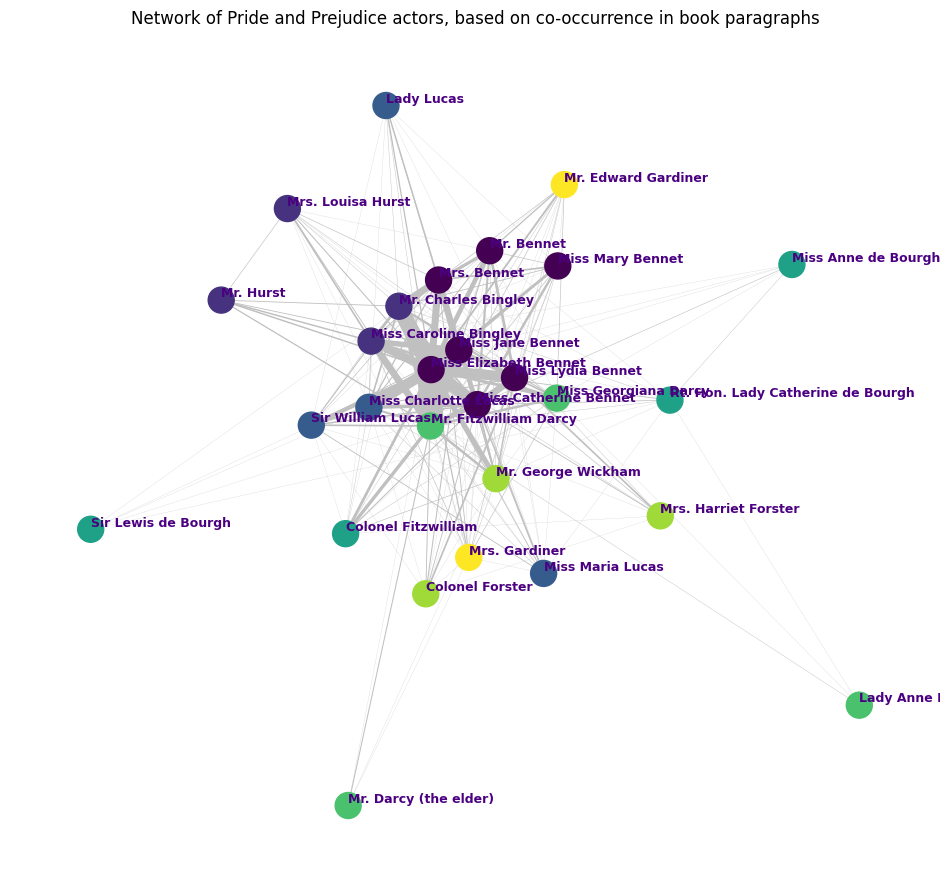

In [45]:
plot_graph(G_pars,
           "Network of Pride and Prejudice actors, based on co-occurrence in book paragraphs",
          #  graph_layout=nx.kamada_kawai_layout(G_pars),
           node_color_modifiers= nx.get_node_attributes(G_pars, 'group'),
           edge_weight_multiplier=0.15)

To examine the tendency of the network actors to group / cluster, we will compute key measures of actor connectedness and tendency to form groups in a network:

In [46]:
from statistics import mean

# network density
den = nx.density(G_pars)
# global clustering coefficient (transitivity)
trans = nx.transitivity(G_pars)
# local clustering coefficient
loc_clust_coef = nx.clustering(G_pars)
avg_loc_clust = mean(loc_clust_coef.values())

print(f"Density: {den:.4f}, transitivity (global clust. coeff.): {trans:.4f}, avg. local clust. coeff: {avg_loc_clust:.4f}")

Density: 0.5582, transitivity (global clust. coeff.): 0.7192, avg. local clust. coeff: 0.7941


Compute also node centralities. In this context, only degree and closeness centrality seem to be meaningful.

In [47]:
degree_centr = nx.degree_centrality(G_pars)
closeness_centr = nx.closeness_centrality(G_pars)

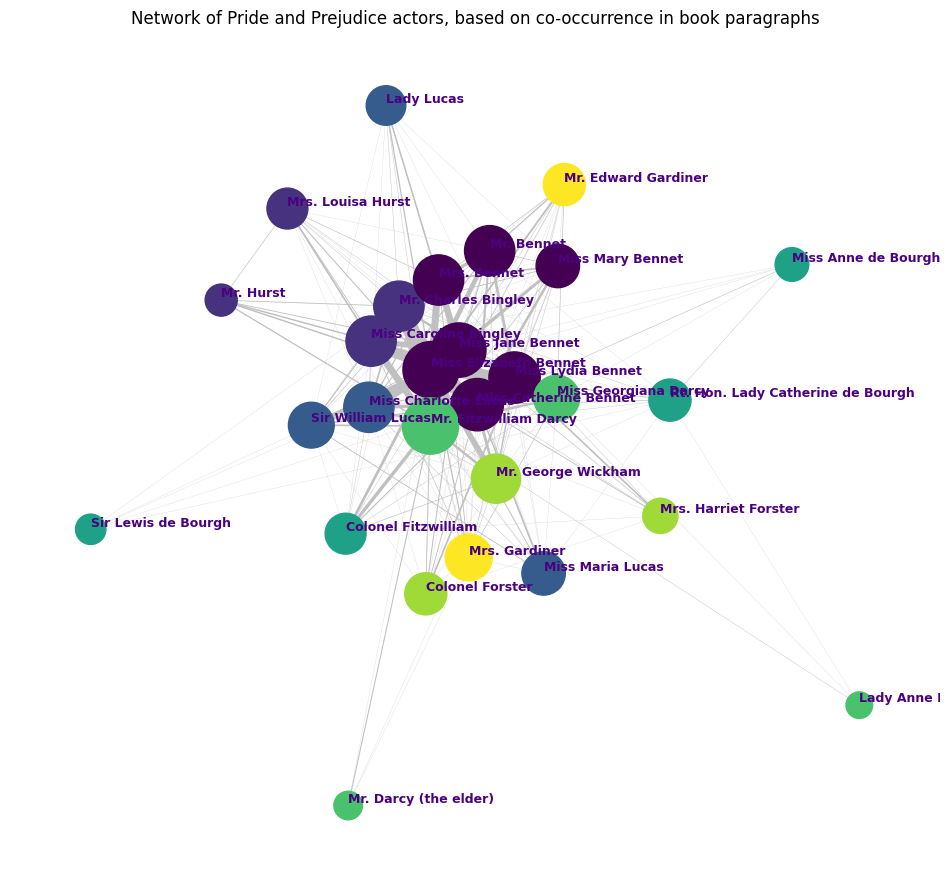

In [48]:
plot_graph(G_pars,
           "Network of Pride and Prejudice actors, based on co-occurrence in book paragraphs",
          #  graph_layout=nx.kamada_kawai_layout(G_pars),
           node_color_modifiers= nx.get_node_attributes(G_pars, 'group'),
           node_size_modifiers=degree_centr,
           edge_weight_multiplier=0.15)

Create a copy of the network for visualisation purposes, as pyvis changes some network attributes.

In [80]:
G_pars_vis = G_pars.copy()

# pyvis using the 'value' attribute of nodes and edges for their visual depiction
# - for nodes, to determine their size
# - for edges, to determine their width

nx.set_node_attributes(G_pars_vis, degree_centr, 'value')

for u, v, attr in G_pars_vis.edges(data=True):
    G_pars_vis[u][v]['value'] = attr['weight'] * 0.5

In [81]:
net = Network(notebook = True, cdn_resources='remote', width="1000px", height="700px", bgcolor='#222222', font_color='white')

net.from_nx(G_pars_vis)

# net.show_buttons(filter_=['physics'])

options = """
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -15000,
      "centralGravity": 0.3,
      "springLength": 95
    },
    "minVelocity": 0.75,
    "stabilization": {
      "enabled": true,
      "iterations": 1000
    }
  }
}
"""
net.set_options(options)

net.save_graph("pride_and_prejudice.html")

# Use IPython to display the file in the Colab cell
IPython.display.HTML(filename="pride_and_prejudice.html")

Examine if clusters can be identified in the network

In [52]:
louvaine_communities = nx.community.louvain_communities(G_pars, weight='weight')

print(f"Number of detected communities: {len(louvaine_communities)}")

Number of detected communities: 4


In [53]:
nx.community.modularity(G_pars, louvaine_communities)

0.07524898045395566

In [54]:
louvain_partitions = {}
for i, community in enumerate(louvaine_communities):
    for node in community:
        louvain_partitions[node] = i

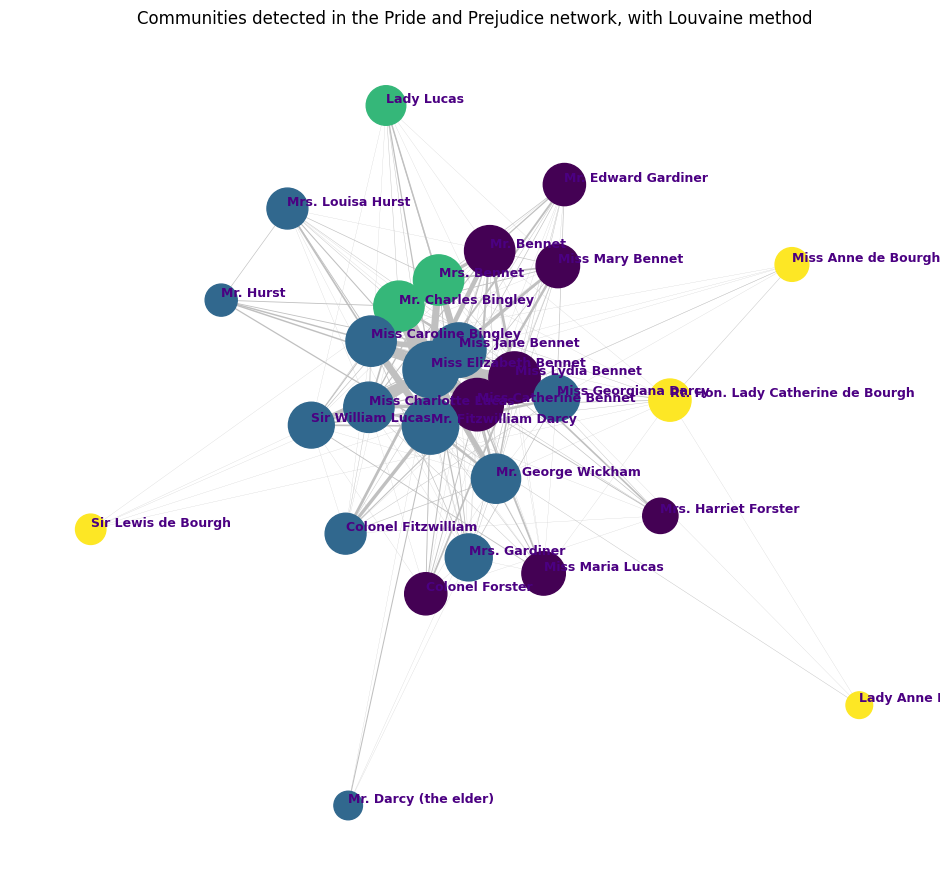

In [55]:
plot_graph(G_pars,
           "Communities detected in the Pride and Prejudice network, with Louvaine method",
          #  graph_layout=nx.kamada_kawai_layout(G_pars),
           node_size_modifiers=degree_centr,
           node_color_modifiers=louvain_partitions,
           edge_weight_multiplier=0.15)

In [56]:
eb_communities = list(nx.community.girvan_newman(G_pars))
partition_modularity_dict = {i : nx.community.modularity(G_pars, partition) for i, partition in enumerate(eb_communities)}
best_partition_item = max(partition_modularity_dict.items(), key=lambda item: item[1])

best_partition = eb_communities[best_partition_item[0]]
eb_modularity = best_partition_item[1]

print(f"Modularity for Edge-betweenness method: {eb_modularity:.4f}")
print(f"Number of clusters: {len(best_partition)}")
print(f"Partitioning: {best_partition}")

Modularity for Edge-betweenness method: 0.0013
Number of clusters: 8
Partitioning: ({'Sir William Lucas', 'Miss Jane Bennet', 'Mr. Fitzwilliam Darcy', 'Miss Maria Lucas', 'Mr. Charles Bingley', 'Mr. Bennet', 'Miss Mary Bennet', 'Mrs. Gardiner', 'Mrs. Louisa Hurst', 'Colonel Fitzwilliam', 'Miss Elizabeth Bennet', 'Miss Caroline Bingley', 'Miss Charlotte Lucas', 'Miss Catherine Bennet', 'Miss Georgiana Darcy', 'Colonel Forster', 'Miss Lydia Bennet', 'Mr. George Wickham', 'Lady Lucas', 'Mrs. Bennet', 'Mr. Edward Gardiner'}, {'Mrs. Harriet Forster'}, {'Miss Anne de Bourgh'}, {'Sir Lewis de Bourgh'}, {'Lady Anne Darcy'}, {'Rt. Hon. Lady Catherine de Bourgh'}, {'Mr. Darcy (the elder)'}, {'Mr. Hurst'})


## Create a chapter-level network

#### Identify set of entities for each chapter and eastablish a connection between any two of them

In [57]:
# data_file = files.upload()
# true_ents_in_pars_df = pd.read_csv("chapters_with_paragraph_level_entities.csv")

In [58]:
chars_edge_list = []

for chapter, chapter_group in true_ents_in_pars_df.groupby('chapter'):
  all_chars = [char for par_chars in chapter_group['chars'] for char in par_chars]
  all_unique_chars = list(set(all_chars))

  n_chars = len(all_unique_chars)
  if n_chars < 2:
    continue

  for i in range(n_chars-1):
    for j in range(i+1, n_chars):
      chars_edge_list.append({
          'chapter': chapter,
          'source' : all_unique_chars[i],
          'target': all_unique_chars[j]
      })

print(len(chars_edge_list))

2724


In [59]:
chars_edge_list_df = pd.DataFrame(chars_edge_list)
chars_edge_list_df.head(10)

,chapter,source,target
0,III_I,Miss Georgiana Darcy,Mr. Fitzwilliam Darcy
1,III_I,Miss Georgiana Darcy,Mr. Charles Bingley
2,III_I,Miss Georgiana Darcy,Mr. George Wickham
3,III_I,Miss Georgiana Darcy,Miss Elizabeth Bennet
4,III_I,Miss Georgiana Darcy,Mrs. Gardiner
5,III_I,Miss Georgiana Darcy,Mr. Edward Gardiner
6,III_I,Mr. Fitzwilliam Darcy,Mr. Charles Bingley
7,III_I,Mr. Fitzwilliam Darcy,Mr. George Wickham
8,III_I,Mr. Fitzwilliam Darcy,Miss Elizabeth Bennet
9,III_I,Mr. Fitzwilliam Darcy,Mrs. Gardiner


In [60]:
weighted_edge_list = chars_edge_list_df.groupby(['source','target']).chapter.count()
weighted_edge_list = weighted_edge_list.reset_index(drop=False)
weighted_edge_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   source   358 non-null    object
 1   target   358 non-null    object
 2   chapter  358 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 8.5+ KB


In [61]:
weighted_edge_list.rename(columns={'chapter':'weight'}, inplace=True)
weighted_edge_list.head()

,source,target,weight
0,Colonel Fitzwilliam,Miss Catherine Bennet,7
1,Colonel Forster,Colonel Fitzwilliam,2
2,Colonel Forster,Lady Lucas,2
3,Colonel Forster,Miss Caroline Bingley,4
4,Colonel Forster,Miss Catherine Bennet,8


In [62]:
weighted_edge_list.sort_values(by='weight', ascending=False).head(20)

,source,target,weight
104,Miss Jane Bennet,Miss Elizabeth Bennet,50
232,Mr. Fitzwilliam Darcy,Miss Elizabeth Bennet,49
198,Mr. Charles Bingley,Miss Elizabeth Bennet,41
113,Miss Jane Bennet,Mr. Fitzwilliam Darcy,41
68,Miss Elizabeth Bennet,Mrs. Bennet,40
63,Miss Elizabeth Bennet,Miss Catherine Bennet,39
239,Mr. Fitzwilliam Darcy,Mr. Charles Bingley,37
110,Miss Jane Bennet,Mr. Charles Bingley,36
116,Miss Jane Bennet,Mrs. Bennet,35
130,Miss Lydia Bennet,Miss Elizabeth Bennet,33


#### Create and explore the network

In [63]:
G_chapters = nx.from_pandas_edgelist(df=weighted_edge_list,
                                    source='source',
                                    target='target',
                                    edge_attr='weight',
                                    create_using=nx.Graph)
print(G_chapters)

Graph with 28 nodes and 331 edges


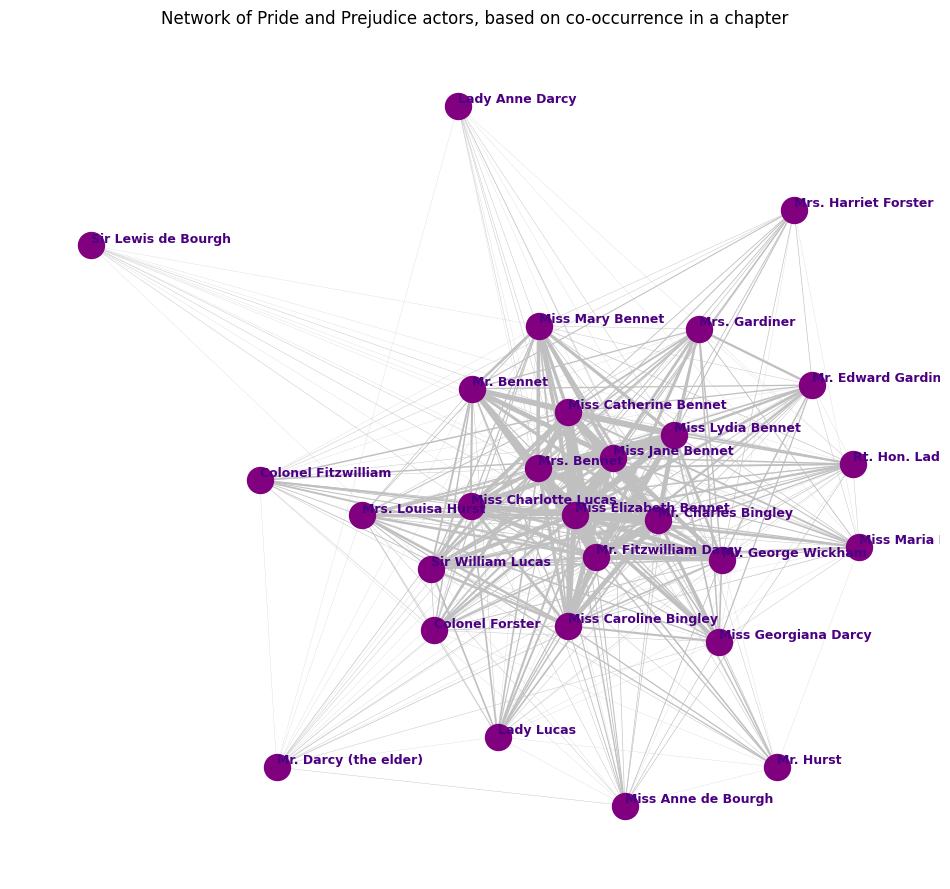

In [64]:
warnings.simplefilter('ignore', UserWarning)

plot_graph(G_chapters,
           "Network of Pride and Prejudice actors, based on co-occurrence in a chapter",
           edge_weight_multiplier=0.15)

In [65]:
from statistics import mean

den = nx.density(G_chapters)
trans = nx.transitivity(G_chapters)
loc_clust_coef = nx.clustering(G_chapters)
avg_loc_clust = mean(loc_clust_coef.values())

print(f"Density: {den:.4f}, transitivity (global clust. coeff.): {trans:.4f}, avg. local clust. coeff: {avg_loc_clust:.4f}")

Density: 0.8757, transitivity (global clust. coeff.): 0.9088, avg. local clust. coeff: 0.9199


### Directions for future exploration

Create a separate network for each book volume (6 in total), so that the evolution of the interaction of the book characters can be traced over time. Compare the networks in terms of the main descriptive statistics and observe how in distinct chapters distinct character groups (location-based groups) interact.
